In [19]:
import teselator as ts
import numpy as np
from math import exp as e
import matplotlib.pyplot as plt

In [20]:
# Crear una ciudad ficticia (datos sinteticos)
ancho_ciudad = 1000
alto_ciudad = 1000
radio_celda = 100

ciudad = ts.hexagon_teselation(0,ancho_ciudad,0,alto_ciudad, radio_celda, 32719)
ciudad['centroide'] = ciudad.centroid
ciudad['m2_op'] = ciudad.apply(lambda row: 10*np.random.exponential(row['cell']*0.25), axis = 1)

,cell,geometry,area,centroide,m2_op
0,1,"POLYGON ((0.000 1000.000, 100.000 1000.000, 15...",25980.762114,POINT (50.000 913.397),2.081173
1,2,"POLYGON ((0.000 826.795, 100.000 826.795, 150....",25980.762114,POINT (50.000 740.192),8.136799
2,3,"POLYGON ((0.000 653.590, 100.000 653.590, 150....",25980.762114,POINT (50.000 566.987),3.642739
3,4,"POLYGON ((0.000 480.385, 100.000 480.385, 150....",25980.762114,POINT (50.000 393.782),33.415378
4,5,"POLYGON ((0.000 307.180, 100.000 307.180, 150....",25980.762114,POINT (50.000 220.577),17.450506


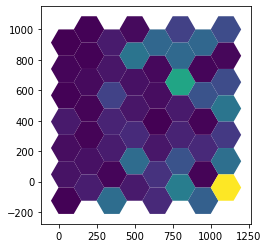

In [23]:
ciudad.plot(column = 'm2_op')
ciudad.head()

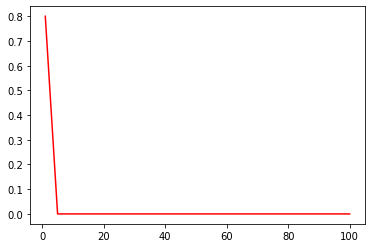

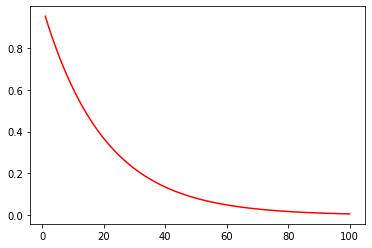

In [22]:
# Definir nuestras funciones de accesibilidad (caminata y vehiculos)

## Caminata (Lineal)
umbral = 5 #min
f_acc_cam = lambda t: 1 -(1/umbral)*t if t<=umbral else 0

## Vehiculos (Exp Negativa)
power = -0.05
f_acc_veh = lambda t: e(1)**(power*t)

def plot(f, start = 1, end = 100, n = 100):
    xs = np.linspace(start, end, n)
    fig = plt.figure()
    plt.plot(xs, [f(x) for x in xs], 'r')
    plt.show()
    
plot(f_acc_cam)  
plot(f_acc_veh)  

In [30]:
## Funciones de distancia y tiempo
def distancia(ciudad, id_origen, id_destino):
    ori = ciudad.loc[ciudad['cell'] == id_origen]['centroide'].iloc[0]
    des = ciudad.loc[ciudad['cell'] == id_destino]['centroide'].iloc[0]
    d = ori.distance(des)
    return d

def tiempo(ciudad, modo, id_origen, id_destino):
    dist_m = distancia(ciudad, id_origen, id_destino)
    if modo == 'cam':
        v = 4 # km/h
    elif modo == 'veh':
        v = 25 # km/h
    t = ((dist_m/1000)/v)*60
    return t

In [34]:
def acc_op(ciudad, modo, celda):
    if modo == 'cam':
        ciudad['aux'] = ciudad.apply(lambda row: row['m2_op']*f_acc_cam(tiempo(ciudad, modo, celda, row['cell'])), axis = 1)
    elif modo == 'veh':
        ciudad['aux'] = ciudad.apply(lambda row: row['m2_op']*f_acc_veh(tiempo(ciudad, modo, celda, row['cell'])), axis = 1)
    acc_total = ciudad['aux'].sum()
    return acc_total

In [35]:
ciudad['acc_op_cam'] = ciudad.apply(lambda row: acc_op(ciudad, 'cam', row['cell']), axis = 1)
ciudad['acc_op_veh'] = ciudad.apply(lambda row: acc_op(ciudad, 'veh', row['cell']), axis = 1)

<AxesSubplot:>

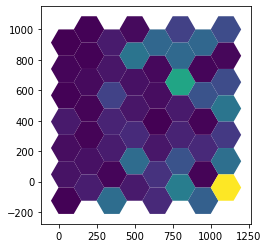

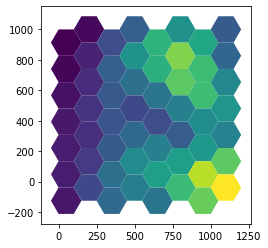

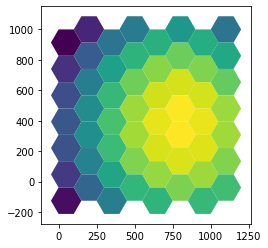

In [36]:
ciudad.plot(column = 'm2_op')
ciudad.plot(column = 'acc_op_cam')
ciudad.plot(column = 'acc_op_veh')

In [37]:
import networkx as nx
import osmnx as ox

In [38]:
p1 = (-34.151351, -70.752434)
p2 = (-34.179492, -70.704044)

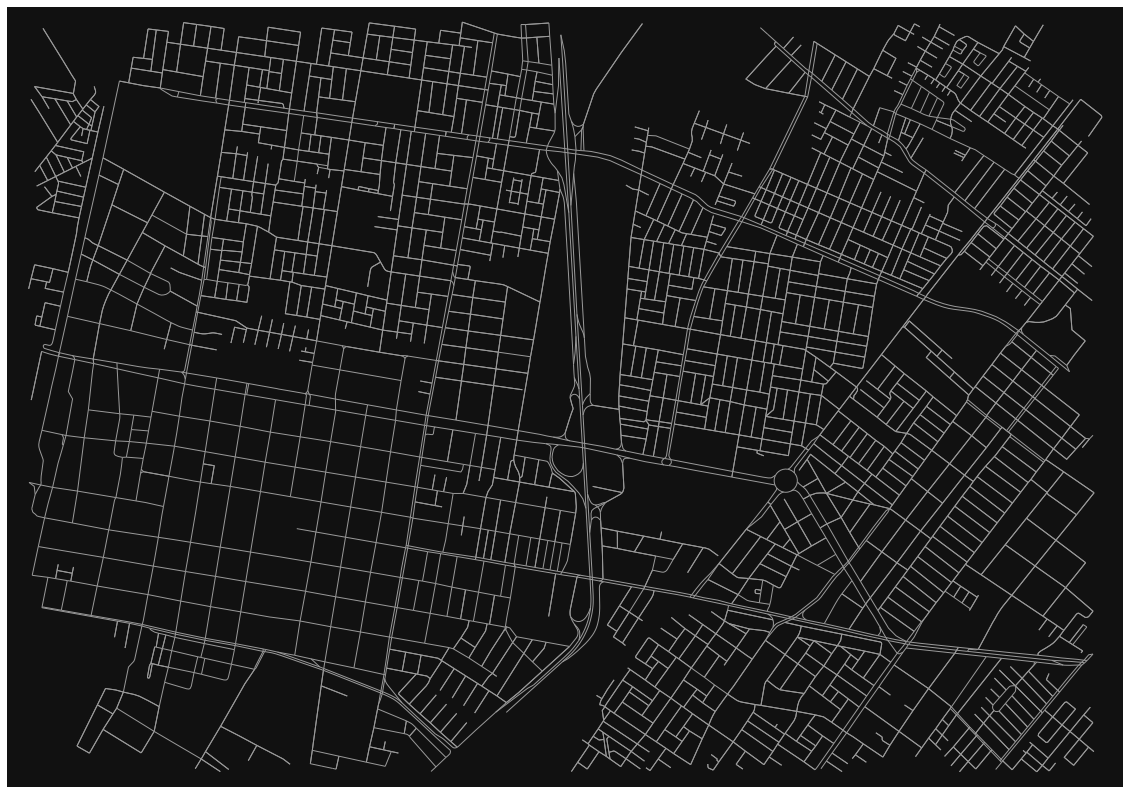

(<Figure size 1440x1440 with 1 Axes>, <AxesSubplot:>)

In [41]:
#net = ox.graph_from_bbox(northLat, southLat, eastLng, westLng, network_type= 'drive')
net = ox.graph_from_bbox(p1[0], p2[0], p1[1], p2[1], network_type= 'drive')
ox.plot_graph(net, figsize = (20,20), node_size = 0)

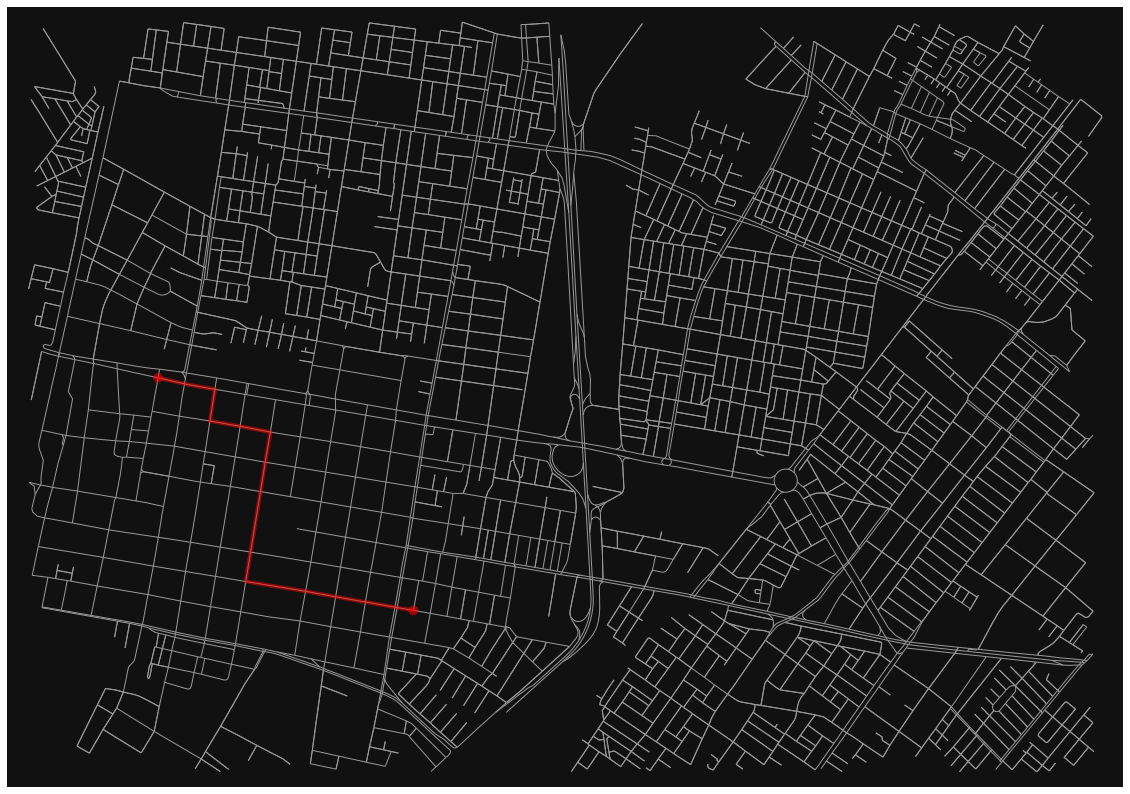

In [43]:
orig_node = ox.get_nearest_node(net, (-34.164603, -70.746707))
dest_node = ox.get_nearest_node(net, (-34.173309, -70.735214))

route = nx.shortest_path(net, orig_node, dest_node, weight = 'length')
cost = nx.shortest_path_length(net, orig_node, dest_node, weight = 'length')
fig, ax = ox.plot_graph_route(net, route, node_size = 0, figsize=(20,20))

In [44]:
cost

1973.958